# Baseline Analysis

Now that we have cleaned our data and removed duplicates, we can take a look at some basic features of the dataset. 

In [32]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PICKLE_PATH = Path("../pickled_data/")

# read in the plays data
game_plays = pd.read_pickle(PICKLE_PATH / 'game_plays')

In [41]:
game_plays.dtypes

play_id                 object
game_id                  int64
team_id_for            float64
team_id_against        float64
event                   object
secondaryType           object
x                      float64
y                      float64
period                   int64
periodType              object
periodTime               int64
periodTimeRemaining    float64
dateTime                object
goals_away               int64
goals_home               int64
description             object
st_x                   float64
st_y                   float64
dtype: object

In [33]:
game_plays['event'].value_counts()

event
Faceoff                     743979
Shot                        698365
Hit                         587574
Stoppage                    581172
Blocked Shot                358851
Missed Shot                 296389
Penalty                     229228
Giveaway                    219864
Takeaway                    173246
Goal                        133345
Period Start                 41663
Period Ready                 41614
Period End                   41609
Period Official              41608
Game End                     12462
Game Scheduled               12458
Shootout Complete             1274
Game Official                 1267
Official Challenge            1028
Early Intermission Start        31
Early Intermission End          31
Emergency Goaltender             5
Name: count, dtype: int64

In [34]:
# Shots by shot type
shots = game_plays[game_plays['event'] == 'Shot']
shot_count = shots.groupby('secondaryType')['play_id'].count().sort_values(ascending=False)

In [35]:
# Goals by shot type
goals = game_plays[game_plays['event'] == 'Goal']
goal_count = goals.groupby('secondaryType')['play_id'].count().sort_values(ascending=False)

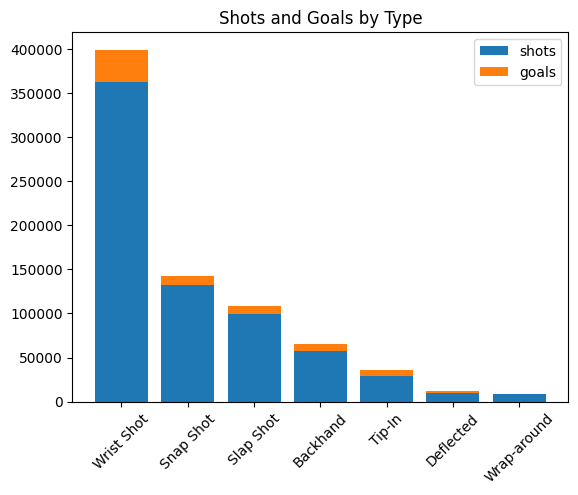

In [ ]:
# create a stacked bar with shots and goal separated by type
shot_types = goal_count.index
counts = {
    "shots": shot_count,
    "goals": goal_count
}

fig, ax = plt.subplots()
bottom=np.zeros(len(goal_count))
for name, count in counts.items():
    ax.bar(shot_types, count, label=name, bottom=bottom)
    bottom += count
    
ax.set_title('Shots and Goals by Type')
ax.legend(loc="upper right")
plt.xticks(rotation=45)
plt.show()


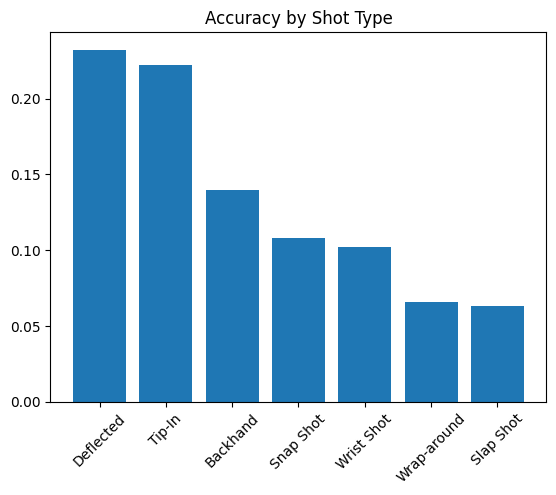

In [31]:
# Plot accuracy (goals/shots) for shot types
accuracy = goal_count / shot_count
accuracy.sort_values(ascending=False, inplace=True)

fig, ax = plt.subplots()
ax.bar(accuracy.index, accuracy)

ax.set_title("Accuracy by Shot Type")
plt.xticks(rotation=45)
plt.show()

In [53]:
def calculate_total_time(df):
    """Calculates total elapsed game time in seconds, given period and time_elapsed (seconds).

    Args:
        df: Pandas DataFrame with 'period' and 'periodTime' (in seconds) columns.

    Returns:
        Pandas DataFrame with a new 'total_time' column (in seconds).
        Returns the original DataFrame if there's an error.
    """
    try:
        # 1. Ensure 'time_elapsed' is numeric:
        df['time_elapsed'] = pd.to_numeric(df['periodTime'], errors='coerce')  # Convert to numeric, handle errors

        # 2. Calculate total seconds for each period:
        df['period_seconds'] = (df['period'] - 1) * 1200  # 1200 seconds per period (20 minutes)

        # 3. Calculate total time:
        df['total_time'] = df['period_seconds'] + df['time_elapsed']

        df = df.drop(columns=['period_seconds'])  # Clean up unnecessary column

        return df
    
    except (TypeError, ValueError) as e:
        print(f"Error during time calculation: {e}")
        return df

shots = calculate_total_time(shots)

/tmp/ipykernel_30224/113349054.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time_elapsed'] = pd.to_numeric(df['periodTime'], errors='coerce')  # Convert to numeric, handle errors
/tmp/ipykernel_30224/113349054.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['period_seconds'] = (df['period'] - 1) * 1200  # 1200 seconds per period (20 minutes)
/tmp/ipykernel_30224/113349054.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

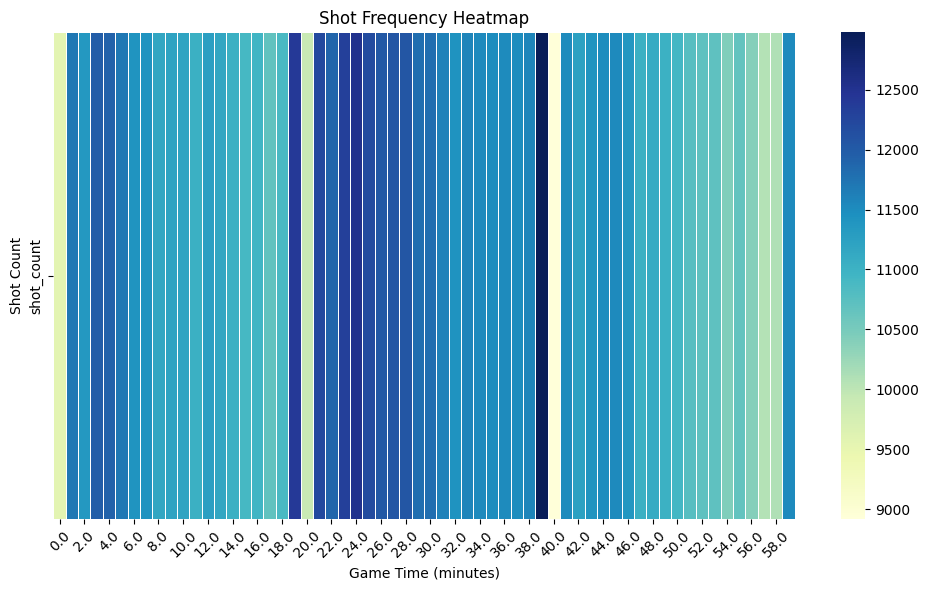

In [ ]:
import seaborn as sns

# Heatmap for shot frequency over time of game
# Create bins for time intervals 
bin_size = 60  # Seconds per bin 
bins = range(0, 3601, bin_size)  # Create the bin edges
shots['time_bin'] = pd.cut(shots['total_time'], bins=bins, right=False, labels=False) # Assign each shot to a time bin

# Aggregate shot counts by time bin:
shot_counts = shots.groupby('time_bin').size().reset_index(name='shot_count')

# Convert time_bin back to seconds for plotting:
shot_counts['time_bin_seconds'] = shot_counts['time_bin'] * bin_size

# Create the heatmap:
plt.figure(figsize=(10, 6)) 

# Convert seconds to minutes for the x-axis labels 
shot_counts['time_bin_minutes'] = shot_counts['time_bin_seconds'] / 60

sns.heatmap(shot_counts.pivot_table(index=None, columns='time_bin_minutes', values='shot_count', aggfunc='sum'), cmap="YlGnBu", linewidths=.5)  # Use pivot_table for heatmap
plt.xlabel("Game Time (minutes)")
plt.ylabel("Shot Count")
plt.title("Shot Frequency Heatmap")

plt.xticks(rotation=45) 
plt.tight_layout() 
plt.show()


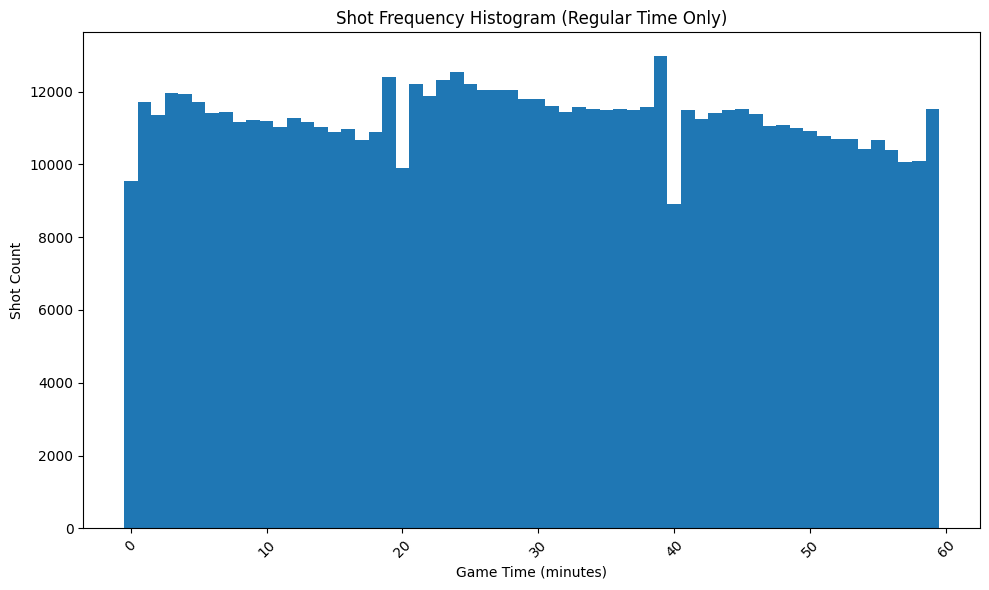

In [63]:
# Histogram of shot count frequency by game time elapsed
plt.figure(figsize=(10, 6))
plt.bar(shot_counts['time_bin_minutes'], shot_counts['shot_count'], width=bin_size/60)  # Use bin_size to determine bar width
plt.xlabel("Game Time (minutes)")
plt.ylabel("Shot Count")
plt.title("Shot Frequency Histogram (Regular Time)")
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.tight_layout()
plt.show()